# Advanced RAG on Hugging Face documentation using LangChain
_Authored by: [Aymeric Roucher](https://huggingface.co/m-ric)_

This notebook demonstrates how you can build an advanced RAG (Retrieval Augmented Generation) for answering a user's question about a specific knowledge base (here, the HuggingFace documentation), using LangChain.

For an introduction to RAG, you can check [this other cookbook](rag_zephyr_langchain)!

RAG systems are complex, with many moving parts: here is a RAG diagram, where we noted in blue all possibilities for system enhancement:

<img src="https://huggingface.co/datasets/huggingface/cookbook-images/resolve/main/RAG_workflow.png" height="700">

> 💡 As you can see, there are many steps to tune in this architecture: tuning the system properly will yield significant performance gains.

In this notebook, we will take a look into many of these blue notes to see how to tune your RAG system and get the best performance.

__Let's dig into the model building!__ First, we install the required model dependancies.

In [1]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [2]:
!node -v

/bin/bash: line 1: node: command not found


In [3]:
!pip install --upgrade pip

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [4]:
!pip install --upgrade Jupyter

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [5]:
!pip install --root-user-action ignore pymilvus PyPDF2 langchain_huggingface plotly widgetsnbextension pandas-profiling torch transformers transformers accelerate bitsandbytes langchain sentence-transformers faiss-gpu openpyxl pacmap datasets langchain-community ragatouille

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [6]:
%reload_ext dotenv
%dotenv

cannot find .env file


In [7]:
from tqdm import tqdm
for i in tqdm(range(10000000)): pass

100%|██████████| 10000000/10000000 [00:01<00:00, 7806521.01it/s]


In [8]:
#from tqdm.notebook import tqdm
import pandas as pd
from typing import Optional, List, Tuple
from datasets import Dataset
import matplotlib.pyplot as plt

pd.set_option(
    "display.max_colwidth", None
)  # This will be helpful when visualizing retriever outputs

### Load your knowledge base

In [9]:
import datasets

ds = datasets.load_dataset("m-ric/huggingface_doc", split="train")

# Using langdocs to retrieve text 

In [10]:
def langdocs():
    from langchain.docstore.document import Document as LangchainDocument

    RAW_KNOWLEDGE_BASE = [
        LangchainDocument(page_content=doc["text"], metadata={"source": doc["source"]})
        for doc in tqdm(ds)
    ]
    return RAW_KNOWLEDGE_BASE 

# Using PDF files to retrieve text

In [11]:
import os
from PyPDF2 import PdfReader
from langchain.docstore.document import Document as LangchainDocument
from tqdm import tqdm

def load_pdf_to_langchain_docs(pdf_directory):
    RAW_KNOWLEDGE_BASE = []
    
    # Get all PDF files in the directory
    pdf_files = [f for f in os.listdir(pdf_directory) if f.endswith('.pdf')]
    print('found the following pdfs:',pdf_files)
    
    for pdf_file in tqdm(pdf_files, desc="Processing PDF files"):
        file_path = os.path.join(pdf_directory, pdf_file)
        
        try:
            # Open the PDF file
            with open(file_path, 'rb') as file:
                pdf_reader = PdfReader(file)
                
                # Process each page
                for page_num, page in enumerate(pdf_reader.pages):
                    text = page.extract_text()
                    
                    if text.strip():  # Only add non-empty pages
                        doc = LangchainDocument(
                            page_content=text,
                            metadata={
                                "source": file_path,
                                "page": page_num + 1
                            }
                        )
                        RAW_KNOWLEDGE_BASE.append(doc)
        except Exception as e:
            print(f"Error processing {pdf_file}: {str(e)}")
    
    return RAW_KNOWLEDGE_BASE

# Usage
#pdf_directory = "/path/to/your/pdf/directory"
#RAW_KNOWLEDGE_BASE = load_pdf_to_langchain_docs(pdf_directory)

#print(f"Total documents loaded: {len(RAW_KNOWLEDGE_BASE)}")

# Optional: Print the first few characters of the first document
#if RAW_KNOWLEDGE_BASE:
#    print("First document preview:")
#    print(RAW_KNOWLEDGE_BASE[0].page_content[:200])  # First 200 characters

# Using Text files

In [12]:
import os
from langchain.docstore.document import Document as LangchainDocument
from tqdm import tqdm

def load_text_to_langchain_docs(text_directory):
    RAW_KNOWLEDGE_BASE = []
    
    # Get all text files in the directory
    text_files = [f for f in os.listdir(text_directory) if f.endswith('.txt')]
    print('found the following text files:', text_files)
    
    for text_file in tqdm(text_files, desc="Processing text files"):
        file_path = os.path.join(text_directory, text_file)
        
        try:
            # Open and read the text file
            with open(file_path, 'r', encoding='utf-8') as file:
                text = file.read()
                
                if text.strip():  # Only add non-empty files
                    doc = LangchainDocument(
                        page_content=text,
                        metadata={
                            "source": file_path,
                            "file": text_file
                        }
                    )
                    RAW_KNOWLEDGE_BASE.append(doc)
        except Exception as e:
            print(f"Error processing {text_file}: {str(e)}")
    
    return RAW_KNOWLEDGE_BASE

# Usage
#text_directory = "./text_files"
#RAW_KNOWLEDGE_BASE = load_text_to_langchain_docs(text_directory)

#print(f"Total documents loaded: {len(RAW_KNOWLEDGE_BASE)}")

# Optional: Print the first few characters of the first document
#if RAW_KNOWLEDGE_BASE:
#    print("First document preview:")
#    print(RAW_KNOWLEDGE_BASE[0].page_content[:200])  # First 200 characters

In [13]:
#RAW_KNOWLEDGE_BASE = langdocs()
#pdf_directory = "./pdf_files/"
#RAW_KNOWLEDGE_BASE = load_pdf_to_langchain_docs(pdf_directory)
text_directory = "./text_files"
RAW_KNOWLEDGE_BASE = load_text_to_langchain_docs(text_directory)
print(f"Total documents loaded: {len(RAW_KNOWLEDGE_BASE)}")

# Optional: Print the first few characters of the first document
if RAW_KNOWLEDGE_BASE:
    print("First document preview:")
    print(RAW_KNOWLEDGE_BASE[0].page_content[:200])  # First 200 characters

found the following text files: ['Facts.txt']


Processing text files: 100%|██████████| 1/1 [00:00<00:00, 5059.47it/s]

Total documents loaded: 1
First document preview:
Samer is the best leader you ever meet
IT staff needs a device called 'AI solution'
Business staff needs system called 'AI use_case x'
CxO staff needs a PoC called 'AI money generator' that can run in


# 1. Retriever - embeddings 🗂️
The __retriever acts like an internal search engine__: given the user query, it returns a few relevant snippets from your knowledge base.

These snippets will then be fed to the Reader Model to help it generate its answer.

So __our objective here is, given a user question, to find the most relevant snippets from our knowledge base to answer that question.__

This is a wide objective, it leaves open some questions. How many snippets should we retrieve? This parameter will be named `top_k`.

How long should these snippets be? This is called the `chunk size`. There's no one-size-fits-all answers, but here are a few elements:
- 🔀 Your `chunk size` is allowed to vary from one snippet to the other.
- Since there will always be some noise in your retrieval, increasing the `top_k` increases the chance to get relevant elements in your retrieved snippets. 🎯 Shooting more arrows increases your probability of hitting your target.
- Meanwhile, the summed length of your retrieved documents should not be too high: for instance, for most current models 16k tokens will probably drown your Reader model in information due to [Lost-in-the-middle phenomenon](https://huggingface.co/papers/2307.03172). 🎯 Give your reader model only the most relevant insights, not a huge pile of books!


> In this notebook, we use Langchain library since __it offers a huge variety of options for vector databases and allows us to keep document metadata throughout the processing__.

### 1.1 Split the documents into chunks

- In this part, __we split the documents from our knowledge base into smaller chunks__ which will be the snippets on which the reader LLM will base its answer.
- The goal is to prepare a collection of **semantically relevant snippets**. So their size should be adapted to precise ideas: too small will truncate ideas, and too large will dilute them.

💡 _Many options exist for text splitting: splitting on words, on sentence boundaries, recursive chunking that processes documents in a tree-like way to preserve structure information... To learn more about chunking, I recommend you read [this great notebook](https://github.com/FullStackRetrieval-com/RetrievalTutorials/blob/main/tutorials/LevelsOfTextSplitting/5_Levels_Of_Text_Splitting.ipynb) by Greg Kamradt._


- **Recursive chunking** breaks down the text into smaller parts step by step using a given list of separators sorted from the most important to the least important separator. If the first split doesn't give the right size or shape of chunks, the method repeats itself on the new chunks using a different separator. For instance with the list of separators `["\n\n", "\n", ".", ""]`:
    - The method will first break down the document wherever there is a double line break `"\n\n"`.
    - Resulting documents will be split again on simple line breaks `"\n"`, then on sentence ends `"."`.
    - Finally, if some chunks are still too big, they will be split whenever they overflow the maximum size.

- With this method, the global structure is well preserved, at the expense of getting slight variations in chunk size.

> [This space](https://huggingface.co/spaces/A-Roucher/chunk_visualizer) lets you visualize how different splitting options affect the chunks you get.

🔬 Let's experiment a bit with chunk sizes, beginning with an arbitrary size, and see how splits work. We use Langchain's implementation of recursive chunking with `RecursiveCharacterTextSplitter`.
- Parameter `chunk_size` controls the length of individual chunks: this length is counted by default as the number of characters in the chunk.
- Parameter `chunk_overlap` lets adjacent chunks get a bit of overlap on each other. This reduces the probability that an idea could be cut in half by the split between two adjacent chunks. We ~arbitrarily set this to 1/10th of the chunk size, you could try different values!

In [14]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

CHUNKSIZE = 180
OVERLAP = 30
# We use a hierarchical list of separators specifically tailored for splitting Markdown documents
# This list is taken from LangChain's MarkdownTextSplitter class
MARKDOWN_SEPARATORS = [
    "\n#{1,6} ",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    "\n\n",
    "\n",
    " ",
    "",
]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=CHUNKSIZE,  # The maximum number of characters in a chunk: we selected this value arbitrarily
    chunk_overlap=OVERLAP,  # The number of characters to overlap between chunks
    add_start_index=True,  # If `True`, includes chunk's start index in metadata
    strip_whitespace=True,  # If `True`, strips whitespace from the start and end of every document
    separators=MARKDOWN_SEPARATORS,
)

docs_processed = []
for doc in RAW_KNOWLEDGE_BASE:
    docs_processed += text_splitter.split_documents([doc])


We also have to keep in mind that when embedding documents, we will use an embedding model that accepts a certain maximum sequence length `max_seq_length`.

So we should make sure that our chunk sizes are below this limit because any longer chunk will be truncated before processing, thus losing relevancy.

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Model's maximum sequence length: 256


100%|██████████| 3/3 [00:00<00:00, 1318.69it/s]


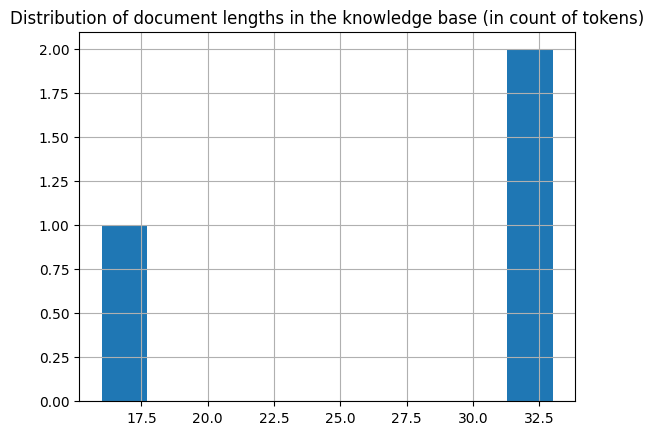

In [15]:
from sentence_transformers import SentenceTransformer
EMBEDDING_MODEL_NAME = "thenlper/gte-small"
EMBEDDING_MODEL_NAME = 'sentence-transformers/all-mpnet-base-v2'
EMBEDDING_MODEL_NAME = 'sentence-transformers/LaBSE'
#EMBEDDING_MODEL_NAME = 'sentence-transformers/all-MiniLM-L6-v2'
# To get the value of the max sequence_length, we will query the underlying `SentenceTransformer` object used in the RecursiveCharacterTextSplitter
print(
    f"Model's maximum sequence length: {SentenceTransformer(EMBEDDING_MODEL_NAME).max_seq_length}"
)

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]


# Plot the distribution of document lengths, counted as the number of tokens
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

In [16]:
# prompt: what is the number of elements in the lengths sereis where the value is higher == 600

sum(i > 384 for i in lengths)


0

👀 As you can see, __the chunk lengths are not aligned with our limit of 512 tokens__, and some documents are above the limit, thus some part of them will be lost in truncation!
 - So we should change the `RecursiveCharacterTextSplitter` class to count length in number of tokens instead of number of characters.
 - Then we can choose a specific chunk size, here we would choose a lower threshold than 512:
    - smaller documents could allow the split to focus more on specific ideas.
    - But too small chunks would split sentences in half, thus losing meaning again: the proper tuning is a matter of balance.

100%|██████████| 1/1 [00:00<00:00, 1733.90it/s]


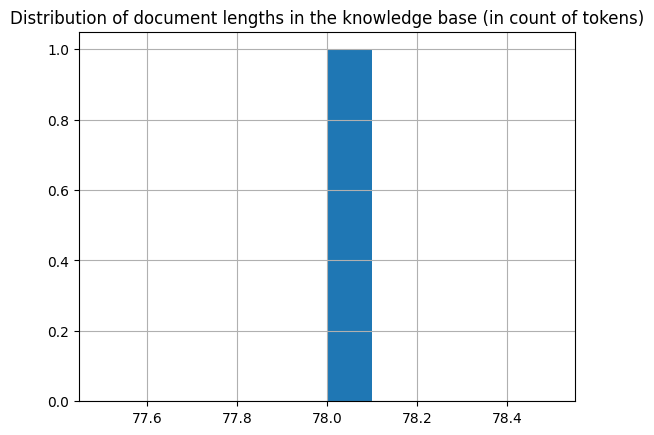

In [17]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from transformers import AutoTokenizer




def split_documents(
    chunk_size: int,
    knowledge_base: List[LangchainDocument],
    tokenizer_name: Optional[str] = EMBEDDING_MODEL_NAME,
) -> List[LangchainDocument]:
    """
    Split documents into chunks of maximum size `chunk_size` tokens and return a list of documents.
    """
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name),
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators=MARKDOWN_SEPARATORS,
    )

    docs_processed = []
    for doc in knowledge_base:
        docs_processed += text_splitter.split_documents([doc])

    # Remove duplicates
    unique_texts = {}
    docs_processed_unique = []
    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)

    return docs_processed_unique


docs_processed = split_documents(
    CHUNKSIZE,  # We choose a chunk size adapted to our model chunk2
    RAW_KNOWLEDGE_BASE,
    tokenizer_name=EMBEDDING_MODEL_NAME,
)

# Let's visualize the chunk sizes we would have in tokens from a common model
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

➡️ Now the chunk length distribution looks better!

### 1.2 Building the vector database

We want to compute the embeddings for all the chunks of our knowledge base: to learn more about sentence embeddings, we recommend reading [this guide](https://osanseviero.github.io/hackerllama/blog/posts/sentence_embeddings/).

#### How does retrieval work?

Once the chunks are all embedded, we store them in a vector database. When the user types in a query, it gets embedded by the same model previously used, and a similarity search returns the closest documents from the vector database.

The technical challenge is thus, given a query vector, to quickly find the nearest neighbors of this vector in the vector database. To do this, we need to choose two things: a distance, and a search algorithm to find the nearest neighbors quickly within a database of thousands of records.

##### Nearest Neighbor search algorithm

There are plentiful choices for the nearest neighbor search algorithm: we go with Facebook's [FAISS](https://github.com/facebookresearch/faiss) since FAISS is performant enough for most use cases, and it is well known and thus widely implemented.

##### Distances

Regarding distances, you can find a good guide [here](https://osanseviero.github.io/hackerllama/blog/posts/sentence_embeddings/#distance-between-embeddings). In short:

- **Cosine similarity** computes the similarity between two vectors as the cosinus of their relative angle: it allows us to compare vector directions regardless of their magnitude. Using it requires normalizing all vectors, to rescale them into unit norm.
- **Dot product** takes into account magnitude, with the sometimes undesirable effect that increasing a vector's length will make it more similar to all others.
- **Euclidean distance** is the distance between the ends of vectors.

You can try [this small exercise](https://developers.google.com/machine-learning/clustering/similarity/check-your-understanding) to check your understanding of these concepts. But once vectors are normalized, [the choice of a specific distance does not matter much](https://platform.openai.com/docs/guides/embeddings/which-distance-function-should-i-use).

Our particular model works well with cosine similarity, so choose this distance, and we set it up both in the Embedding model, and in the `distance_strategy` argument of our FAISS index. With cosine similarity, we have to normalize our embeddings.

🚨👇 The cell below takes a few minutes to run on A10G!

In [19]:
from langchain.vectorstores import Milvus
from langchain_community.embeddings import HuggingFaceEmbeddings
from pymilvus import connections, utility

# Your existing embedding model setup
embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},  # Set `True` for cosine similarity
)

# Milvus connection settings
MILVUS_HOST = "localhost"  # Change if your Milvus server is on a different host
MILVUS_PORT = "19530"      # Default port for Milvus
COLLECTION_NAME = "pdfcollection"  # Choose a name for your collection

# Connect to Milvus
connections.connect(host=MILVUS_HOST, port=MILVUS_PORT)

# Create Milvus vector store
KNOWLEDGE_VECTOR_DATABASE = Milvus.from_documents(
    documents=docs_processed,
    embedding=embedding_model,
    collection_name=COLLECTION_NAME,
    connection_args={"host": MILVUS_HOST, "port": MILVUS_PORT},
)

# Ensure the collection is loaded into memory for faster queries
utility.load_collection(COLLECTION_NAME)

# Example of how to perform a similarity search
query = "What is the R660 ?"
results = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query, k=4)  # k is the number of results to return

# Print results
for doc in results:
    print(doc.page_content)
    print(doc.metadata)
    print("---")

# When you're done, you can release the collection from memory
utility.release_collection(COLLECTION_NAME)

# Disconnect from Milvus when you're completely done
connections.disconnect(alias="default")

MilvusException: <MilvusException: (code=2, message=Fail connecting to server on localhost:19530, illegal connection params or server unavailable)>

In [ ]:
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},  # Set `True` for cosine similarity
)

KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents(
    docs_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE
)

👀 To visualize the search for the closest documents, let's project our embeddings from 384 dimensions down to 2 dimensions using PaCMAP.

💡 _We chose PaCMAP rather than other techniques such as t-SNE or UMAP, since [it is efficient (preserves local and global structure), robust to initialization parameters and fast](https://www.nature.com/articles/s42003-022-03628-x#Abs1)._

In [ ]:
# Embed a user query in the same space
user_query = "what is the R660 ?"
query_vector = embedding_model.embed_query(user_query)

In [ ]:
import pacmap
import numpy as np
import plotly.express as px

embedding_projector = pacmap.PaCMAP(
    n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0, random_state=1
)

embeddings_2d = [
    list(KNOWLEDGE_VECTOR_DATABASE.index.reconstruct_n(idx, 1)[0])
    for idx in range(len(docs_processed))
] + [query_vector]

# Fit the data (the index of transformed data corresponds to the index of the original data)
documents_projected = embedding_projector.fit_transform(
    np.array(embeddings_2d), init="pca"
)

In [ ]:
df = pd.DataFrame.from_dict(
    [
        {
            "x": documents_projected[i, 0],
            "y": documents_projected[i, 1],
            "source": docs_processed[i].metadata["source"].split("/")[1],
            "extract": docs_processed[i].page_content[:100] + "...",
            "symbol": "circle",
            "size_col": 4,
        }
        for i in range(len(docs_processed))
    ]
    + [
        {
            "x": documents_projected[-1, 0],
            "y": documents_projected[-1, 1],
            "source": "User query",
            "extract": user_query,
            "size_col": 100,
            "symbol": "star",
        }
    ]
)

# Visualize the embedding
fig = px.scatter(
    df,
    x="x",
    y="y",
    color="source",
    hover_data="extract",
    size="size_col",
    symbol="symbol",
    color_discrete_map={"User query": "black"},
    width=1000,
    height=700,
)
fig.update_traces(
    marker=dict(opacity=1, line=dict(width=0, color="DarkSlateGrey")),
    selector=dict(mode="markers"),
)
fig.update_layout(
    legend_title_text="<b>Chunk source</b>",
    title="<b>2D Projection of Chunk Embeddings via PaCMAP</b>",
)
fig.show()

<img src="https://huggingface.co/datasets/huggingface/cookbook-images/resolve/main/PaCMAP_embeddings.png" height="700">


➡️ On the graph above, you can see a spatial representation of the knowledge base documents. As the vector embeddings represent the document's meaning, their closeness in meaning should be reflected in their embedding's closeness.

The user query's embedding is also shown: we want to find the `k` documents that have the closest meaning, thus we pick the `k` closest vectors.

In the LangChain vector database implementation, this search operation is performed by the method `vector_database.similarity_search(query)`.

Here is the result:

In [ ]:
print(f"\nStarting retrieval for {user_query=}...")
retrieved_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query=user_query, k=5)

for doc in retrieved_docs:
#     print(doc.page_content)
#     print(doc.metadata)
  print(
    "\n==================================Top document=================================="
)
  print(doc.page_content)
  print("==================================Metadata==================================")
  print(doc.metadata)

# 2. Reader - LLM 💬

In this part, the __LLM Reader reads the retrieved context to formulate its answer.__

There are substeps that can all be tuned:
1. The content of the retrieved documents is aggregated together into the "context", with many processing options like _prompt compression_.
2. The context and the user query are aggregated into a prompt and then given to the LLM to generate its answer.

### 2.1. Reader model

The choice of a reader model is important in a few aspects:
- the reader model's `max_seq_length` must accommodate our prompt, which includes the context output by the retriever call: the context consists of 5 documents of 512 tokens each, so we aim for a context length of 4k tokens at least.
- the reader model

For this example, we chose [`HuggingFaceH4/zephyr-7b-beta`](https://huggingface.co/HuggingFaceH4/zephyr-7b-beta), a small but powerful model.

With many models being released every week, you may want to substitute this model to the latest and greatest. The best way to keep track of open source LLMs is to check the [Open-source LLM leaderboard](https://huggingface.co/spaces/HuggingFaceH4/open_llm_leaderboard).

To make inference faster, we will load the quantized version of the model:

In [ ]:
from transformers import pipeline
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

READER_MODEL_NAME = "HuggingFaceH4/zephyr-7b-beta"
READER_MODEL_NAME = "Qwen/Qwen2.5-Coder-7B-Instruct"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)
model = AutoModelForCausalLM.from_pretrained(
    READER_MODEL_NAME, quantization_config=bnb_config
)
tokenizer = AutoTokenizer.from_pretrained(READER_MODEL_NAME)

READER_LLM = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    do_sample=True,
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=500,
)

In [ ]:
READER_LLM("what is the R660:")

### 2.2. Prompt

The RAG prompt template below is what we will feed to the Reader LLM: it is important to have it formatted in the Reader LLM's chat template.

We give it our context and the user's question.

In [ ]:
prompt_in_chat_format = [
    {
        "role": "system",
        "content": """Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.""",
    },
    {
        "role": "user",
        "content": """Context:
{context}
---
Now here is the question you need to answer.

Question: {question}""",
    },
]
RAG_PROMPT_TEMPLATE = tokenizer.apply_chat_template(
    prompt_in_chat_format, tokenize=False, add_generation_prompt=True
)
print(RAG_PROMPT_TEMPLATE)

Let's test our Reader on our previously retrieved documents!

In [ ]:
retrieved_docs_text = [
    doc.page_content for doc in retrieved_docs
]  # We only need the text of the documents
context = "\nExtracted documents:\n"
context += "".join(
    [f"Document {str(i)}:::\n" + doc for i, doc in enumerate(retrieved_docs_text)]
)

final_prompt = RAG_PROMPT_TEMPLATE.format(
    question="How to create a pipeline object?", context=context
)

# Redact an answer
answer = READER_LLM(final_prompt)[0]["generated_text"]
print(answer)

### 2.3. Reranking

A good option for RAG is to retrieve more documents than you want in the end, then rerank the results with a more powerful retrieval model before keeping only the `top_k`.

For this, [Colbertv2](https://arxiv.org/abs/2112.01488) is a great choice: instead of a bi-encoder like our classical embedding models, it is a cross-encoder that computes more fine-grained interactions between the query tokens and each document's tokens.

It is easily usable thanks to [the RAGatouille library](https://github.com/bclavie/RAGatouille).

In [ ]:
from ragatouille import RAGPretrainedModel

RERANKER = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")

# 3. Assembling it all!

In [ ]:
from transformers import Pipeline


def answer_with_rag(
    question: str,
    llm: Pipeline,
    knowledge_index: FAISS,
    reranker: Optional[RAGPretrainedModel] = None,
    num_retrieved_docs: int = 30,
    num_docs_final: int = 5,
) -> Tuple[str, List[LangchainDocument]]:
    # Gather documents with retriever
    print("=> Retrieving documents...")
    relevant_docs = knowledge_index.similarity_search(
        query=question, k=num_retrieved_docs
    )
    relevant_docs = [doc.page_content for doc in relevant_docs]  # Keep only the text

    # Optionally rerank results
    if reranker:
        print("=> Reranking documents...")
        relevant_docs = reranker.rerank(question, relevant_docs, k=num_docs_final)
        relevant_docs = [doc["content"] for doc in relevant_docs]

    relevant_docs = relevant_docs[:num_docs_final]

    # Build the final prompt
    context = "\nExtracted documents:\n"
    context += "".join(
        [f"Document {str(i)}:::\n" + doc for i, doc in enumerate(relevant_docs)]
    )

    final_prompt = RAG_PROMPT_TEMPLATE.format(question=question, context=context)

    # Redact an answer
    print("=> Generating answer...")
    answer = llm(final_prompt)[0]["generated_text"]

    return answer, relevant_docs

Let's see how our RAG pipeline answers a user query.

In [ ]:
import time

def measure_time(func):
    def microseconds_to_readable(microseconds):
        # Convert microseconds to seconds
        total_seconds = microseconds / 1_000_000

        # Calculate hours, minutes, and remaining seconds
        hours, remainder = divmod(total_seconds, 3600)
        minutes, seconds = divmod(remainder, 60)

        # Format the result
        if hours > 0:
            return f"{int(hours)}h {int(minutes)}m {seconds:.2f}s"
        elif minutes > 0:
            return f"{int(minutes)}m {seconds:.2f}s"
        else:
            return f"{seconds:.2f}s"
    def wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        execution_time1 = (end_time - start_time) * 1_000_000  # Convert to microseconds
        execution_time = microseconds_to_readable(execution_time1)
        print(f"Function '{func.__name__}' took {execution_time}")
        return result
    return wrapper

In [ ]:
@measure_time
def ragthis(strvar):
    answer, relevant_docs = answer_with_rag(
        question, READER_LLM, KNOWLEDGE_VECTOR_DATABASE, reranker=RERANKER
    )
    return answer, relevant_docs

In [ ]:
import sys
from collections import abc
import numpy as np

def get_size(obj, seen=None):
    """Recursively calculate size of objects in memory"""
    size = sys.getsizeof(obj)
    if seen is None:
        seen = set()
    obj_id = id(obj)
    if obj_id in seen:
        return 0
    seen.add(obj_id)
    if isinstance(obj, dict):
        size += sum([get_size(v, seen) for v in obj.values()])
        size += sum([get_size(k, seen) for k in obj.keys()])
    elif hasattr(obj, '__dict__'):
        size += get_size(obj.__dict__, seen)
    elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
        size += sum([get_size(i, seen) for i in obj])
    return size

def size_in_mb(obj):
    """Get size of object in MB"""
    bytes_size = get_size(obj)
    mb_size = bytes_size / (1024 * 1024)
    return f"{mb_size:.2f} MB"

# Example usage

print(f"Size of the RAW_KNOWLEDGE_BASE: {size_in_mb(RAW_KNOWLEDGE_BASE)}")


print(f"Size of the docs_processed: {size_in_mb(docs_processed)}")
print(f"Size of KNOWLEDGE_VECTOR_DATABASE: {size_in_mb(KNOWLEDGE_VECTOR_DATABASE)}")

In [ ]:
import re
from langchain.docstore.document import Document as LangchainDocument

def count_words(text):
    # Split the text into words using regex
    # This considers any sequence of non-whitespace characters as a word
    words = re.findall(r'\S+', text)
    return len(words)

def analyze_knowledge_base(documents):
    total_chars = 0
    total_words = 0
    
    for doc in documents:
        if isinstance(doc, LangchainDocument):
            content = doc.page_content
            total_chars += len(content)
            total_words += count_words(content)
    
    return total_chars, total_words

# Assuming RAW_KNOWLEDGE_BASE is already defined
total_characters, total_words = analyze_knowledge_base(RAW_KNOWLEDGE_BASE)

print(f"Total number of characters: {'{:,d}'.format(total_characters)}")
print(f"Total number of words: {'{:,d}'.format(total_words)}")

# If you want to know the average per document:
num_documents = len(RAW_KNOWLEDGE_BASE)
avg_characters = total_characters / num_documents
avg_words = total_words / num_documents

print(f"Number of documents: {'{:,d}'.format(num_documents)}")
#print(f"Average characters per document: {avg_characters:.2f}")
#print(f"Average words per document: {avg_words:.2f}")

In [ ]:

print(f"Total number of characters: {'{:,d}'.format(total_characters)}")
print(f"Total number of words: {'{:,d}'.format(total_words)}")

# If you want to know the average per document:
num_documents = len(RAW_KNOWLEDGE_BASE)

print(f"Number of documents: {'{:,d}'.format(num_documents)}")
print(f"Size of the RAW_KNOWLEDGE_BASE: {size_in_mb(RAW_KNOWLEDGE_BASE)}")
print(f"Size of the docs_processed: {size_in_mb(docs_processed)}")
print(f"Size of KNOWLEDGE_VECTOR_DATABASE: {size_in_mb(KNOWLEDGE_VECTOR_DATABASE)}")

In [ ]:
#question = "Answer in not more than 10 words, what is the R660?"
question = "Answer by 'Yes' or 'No'. Is the R660 a server?"
question = "how much is maximum memory in the R660 ?, Answer and convert the size to TB one or two words"
answer, relevant_docs = ragthis(question)

## 

In [ ]:
print("==================================Answer==================================")
print(f"{answer}")
print("==================================Source docs==================================")
for i, doc in enumerate(relevant_docs):
    print(f"Document {i}------------------------------------------------------------")
    print(doc)

### ✅ We now have a fully functional, performant RAG system. That's it for today! Congratulations for making it to the end 🥳


# To go further 🗺️

This is not the end of the journey! You can try many steps to improve your RAG system. We recommend doing so in an iterative way: bring small changes to the system and see what improves performance.

### Setting up an evaluation pipeline

- 💬 "You cannot improve the model performance that you do not measure", said Gandhi... or at least Llama2 told me he said it. Anyway, you should absolutely start by measuring performance: this means building a small evaluation dataset, and then monitor the performance of your RAG system on this evaluation dataset.

### Improving the retriever

🛠️ __You can use these options to tune the results:__

- Tune the chunking method:
    - Size of the chunks
    - Method: split on different separators, use [semantic chunking](https://python.langchain.com/docs/modules/data_connection/document_transformers/semantic-chunker)...
- Change the embedding model

👷‍♀️ __More could be considered:__
- Try another chunking method, like semantic chunking
- Change the index used (here, FAISS)
- Query expansion: reformulate the user query in slightly different ways to retrieve more documents.

### Improving the reader

🛠️ __Here you can try the following options to improve results:__
- Tune the prompt
- Switch reranking on/off
- Choose a more powerful reader model

💡 __Many options could be considered here to further improve the results:__
- Compress the retrieved context to keep only the most relevant parts to answer the query.
- Extend the RAG system to make it more user-friendly:
    - cite source
    - make conversational